In [1]:
import time
from IPython.display import display, clear_output

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

from jax import vmap
from jax import random

### Rendering functions

In [2]:
@vmap 
def normal(theta):
    return jnp.array([jnp.cos(theta), jnp.sin(theta)])

def render(state):
    box_size = state.simulator_state.box_size[0]
    max_agents = state.simulator_state.max_agents[0]

    plt.figure(figsize=(6, 6))
    plt.xlim(0, box_size)
    plt.xlim(0, box_size)

    exists_agents, exists_objects = state.entity_state.exists[:max_agents], state.entity_state.exists[max_agents:] 
    exists_agents = jnp.where(exists_agents != 0)
    exists_objects = jnp.where(exists_objects != 0)

    agents_pos = state.entity_state.position.center[:max_agents][exists_agents]
    agents_theta = state.entity_state.position.orientation[:max_agents][exists_agents][exists_agents]
    agents_diameter = state.entity_state.diameter[:max_agents][exists_agents][exists_agents]
    objects_pos = state.entity_state.position.center[max_agents:][exists_objects]
    object_diameter = state.entity_state.diameter[max_agents:][exists_objects]

    x_agents, y_agents = agents_pos[:, 0], agents_pos[:, 1]
    agents_colors_rgba = [colors.to_rgba(np.array(c), alpha=1.) for c in state.agent_state.color[exists_agents]]
    x_objects, y_objects = objects_pos[:, 0], objects_pos[:, 1]
    object_colors_rgba = [colors.to_rgba(np.array(c), alpha=1.) for c in state.object_state.color[exists_objects]]

    n = normal(agents_theta)

    arrow_length = 3  
    size_scale = 30  
    dx = arrow_length * n[:, 0]
    dy = arrow_length *  n[:, 1]
    plt.quiver(x_agents, y_agents, dx, dy, color=agents_colors_rgba, scale=1, scale_units='xy', headwidth=0.8, angles='xy', width=0.01)
    plt.scatter(x_agents, y_agents, c=agents_colors_rgba, s=agents_diameter*size_scale, label='agents')
    plt.scatter(x_objects, y_objects, c=object_colors_rgba, s=object_diameter*size_scale, label='objects')

    plt.title('State')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()

    plt.show()

def render_history(state_history, pause=0.001, skip_frames=1):
    box_size = state_history[0][3].box_size[0]
    max_agents = state_history[0][3].max_agents[0]
    print(box_size) 
    print(max_agents) 
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)

    for t in range(0, len(state_history), skip_frames):
        entity_state, agent_state, object_state, simulator_state = state_history[t]

        exists_agents, exists_objects = entity_state.exists[:max_agents], entity_state.exists[max_agents:] 
        exists_agents = jnp.where(exists_agents != 0)
        exists_objects = jnp.where(exists_objects != 0)

        agents_pos = entity_state.position.center[:max_agents][exists_agents]
        agents_theta = entity_state.position.orientation[:max_agents][exists_agents][exists_agents]
        agents_diameter = entity_state.diameter[:max_agents][exists_agents][exists_agents]
        objects_pos = entity_state.position.center[max_agents:][exists_objects]
        object_diameter = entity_state.diameter[max_agents:][exists_objects]

        x_agents, y_agents = agents_pos[:, 0], agents_pos[:, 1]
        agents_colors_rgba = [colors.to_rgba(np.array(c), alpha=1.) for c in agent_state.color[exists_agents]]
        x_objects, y_objects = objects_pos[:, 0], objects_pos[:, 1]
        object_colors_rgba = [colors.to_rgba(np.array(c), alpha=1.) for c in object_state.color[exists_objects]]

        n = normal(agents_theta)

        arrow_length = 3  
        size_scale = 30 
        dx = arrow_length * n[:, 0]
        dy = arrow_length *  n[:, 1]

        ax.clear()
        ax.set_xlim(0, box_size)
        ax.set_ylim(0, box_size)
        
        ax.quiver(x_agents, y_agents, dx, dy, color=agents_colors_rgba, scale=1, scale_units='xy', headwidth=0.8, angles='xy', width=0.01)
        ax.scatter(x_agents, y_agents, c=agents_colors_rgba, s=agents_diameter*size_scale, label='agents')
        ax.scatter(x_objects, y_objects, c=object_colors_rgba, s=object_diameter*size_scale, label='objects')

        ax.set_title(f'Timestep: {t+1}')
        ax.set_xlabel('X Position')
        ax.set_ylabel('Y Position')
        ax.legend()
        
        display(fig)
        clear_output(wait=True)
        time.sleep(pause)

    plt.close(fig)

### Simulation state

The ***state*** of a simulation is composed of 4 elements:


- ***Simulator State***: This element contains general information about the simulator, such as the size of the environment, the maximum number of agents and objects, and other global settings that define the overall behavior of the simulation and ... parameters for the connection with clients if run in server mode.

- ***Entity State***: This element stores information which is common to all types of entities (i.e. common to agents and objects). It typically includes physical parameters such as position, speed, mass, or friction. The reason they are located here instead of the Agent or Object States is that it facilitates the computation of the physical simulation step. We are considering simplifying this in the future.

- ***Agent State***: This element focuses on the agents in the simulation, which are primarily based on [Braitenberg vehicles](https://en.wikipedia.org/wiki/Braitenberg_vehicle) at the moment. It includes information about their behavior, wheel diameter, speed multipliers, maximum speed, and other agent-specific parameters that determine how they react to their environment and entities within it.

- ***Object State***: This element provides information about the objects present in the simulation. Currently, it mainly consists of the objects' color, but it can be expanded to include additional object-specific parameters as needed.


In the next cells, we'll explain step by step how to initialize a state.

<!-- All parameters used in a simulation

<div style="font-size: 80%;">

```yaml
agents:
  behavior: 1
  color: blue
  max_speed: 10.0
  prox_cos_min: 0.0
  prox_dist_max: 40.0
  speed_mul: 1.0
  theta_mul: 1.0
  wheel_diameter: 2.0

entities:
  agents_positions: null
  diameter: 5.0
  existing_agents: null
  existing_objects: null
  friction: 0.1
  mass_center: 1.0
  mass_orientation: 0.125
  objects_positions: null
  seed: 0

objects:
  color: red

simulator:
  box_size: 100.0
  collision_alpha: 0.5
  collision_eps: 0.1
  dt: 0.1
  freq: 40.0
  max_agents: 10
  max_objects: 2
  neighbor_radius: 100.0
  num_steps_lax: 4
  to_jit: true
  use_fori_loop: false


```

</div> -->

### Create simulator state

contains general info abt the simulator, n objects and agents ... but also parameters abt simulation running (use jit or not, use fori_loop, num steps per update loop ...) parameters abt sim speed and update freq for interface (dt, freq), parameters abt physics of the environment (collision_alpha, collision_eps)

In [3]:
from vivarium.simulator.states import SimulatorState

box_size = 100. # size of the environment (it is a torus)
max_agents = 10 # max number of agents in the environment 
max_objects = 2 # max number of objects in the environment
num_steps_lax = 4 # Number of updates in the environment per steps 
dt = 0.01 # dt used in physics simulation updates
freq = -1 # frequency of steps (set to -1 if not used with a client)
neighbor_radius = 100. # radius entities to compute their neigbors (useful with large simulations)
to_jit = True # wether to jit the update function in the simulation or not 
use_fori_loop = False # wether to use fori_loops in the step function (accelerate the simulation)
collision_alpha = 0.5 # collision parameter in the physics engine
collision_eps = 0.1 # collision parameter in the physics engine

simulator_state = SimulatorState(
    idx=jnp.array([0]),
    box_size=jnp.array([box_size]),              
    max_agents=jnp.array([max_agents]),
    max_objects=jnp.array([max_objects]),
    num_steps_lax=jnp.array([num_steps_lax], dtype=int),
    dt=jnp.array([dt], dtype=float),
    freq=jnp.array([freq], dtype=float),
    neighbor_radius=jnp.array([neighbor_radius], dtype=float),
    to_jit= jnp.array([1*to_jit]),
    use_fori_loop=jnp.array([1*use_fori_loop]),
    collision_alpha=jnp.array([collision_alpha]),
    collision_eps=jnp.array([collision_eps]))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Create entities state

Contains all physical parameters (position, mass, momentum, friction ...) about all entities of the system (agents, objects). We store all the data in jax arrays of length n_entities (max_agents + max_objects). Because those arrays encompass information about agents but also objects, we define an array entity_types to know the type of each entity. We also have an array called exists, that defines which entity exist or not. This is because we have to keep arrays of same shape with jax, so we can't just add new agents to a list for example (that is also why we need to define max_agents / objects in advance).

In [4]:
from vivarium.simulator.states import EntityState, EntityType
from jax_md.rigid_body import RigidBody

n_dims = 2 # 2D world
diameter = 5. # diameter of entities
friction = 0.1 # friction of entities
mass_center = 1. # mass of entities 
mass_orientation = 0.125 # mass orientation of entities
existing_agents = 10 # defines how many agents exist among the max number of agents
existing_objects = 2 # same for objects
seed = 0 # random seed used to initialize positions and orientations

n_entities = max_agents + max_objects # we store the entities data in jax arrays of length max_agents + max_objects 

key = random.PRNGKey(seed)
key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

# Assign random positions to each entity in the environment
agents_positions = random.uniform(key_agents_pos, (max_agents, n_dims)) * box_size
objects_positions = random.uniform(key_objects_pos, (max_objects, n_dims)) * box_size
positions = jnp.concatenate((agents_positions, objects_positions))

# Assign random orientations between 0 and 2*pi to each entity
orientations = random.uniform(key_orientations, (n_entities,)) * 2 * jnp.pi

# Assign types to the entities
agents_entities = jnp.full(max_agents, EntityType.AGENT.value)
object_entities = jnp.full(max_objects, EntityType.OBJECT.value)
entity_types = jnp.concatenate((agents_entities, object_entities), dtype=int)

# Define arrays with existing entities
exists_agents = jnp.concatenate((jnp.ones((existing_agents)), jnp.zeros((max_agents - existing_agents))))
exists_objects = jnp.concatenate((jnp.ones((existing_objects)), jnp.zeros((max_objects - existing_objects))))
exists = jnp.concatenate((exists_agents, exists_objects), dtype=int)

# We use the RigidBody class from jax_md to represent the position, force and mass of entities 
# see https://jax-md.readthedocs.io/en/main/jax_md.rigid_body.html
entity_state = EntityState(
    position=RigidBody(center=positions, orientation=orientations),
    momentum=None,
    force=RigidBody(center=jnp.zeros((n_entities, 2)), orientation=jnp.zeros(n_entities)),
    mass=RigidBody(center=jnp.full((n_entities, 1), mass_center), orientation=jnp.full((n_entities), mass_orientation)),
    entity_type=entity_types,
    entity_idx = jnp.array(list(range(max_agents)) + list(range(max_objects))),
    diameter=jnp.full((n_entities), diameter),
    friction=jnp.full((n_entities), friction),
    exists=exists
    )

### Create agents state

All information about the agents that are not shared by other entities. At the moment, the agents are braitenberg vehicles, that is why they have behaviors, wheels, motors, proximeter ... 

The behaviors perceive the environment trough proximeters, and the behavior determine motor activations according to proximter activations. They are implemented in [this file](../vivarium/simulator/behaviors.py) 

In [5]:
from vivarium.simulator.states import AgentState

behavior = 1 # 1 of the 4 pre-implement behavior of agents
wheel_diameter = 2. # diameter of vehicle wheels
speed_mul = 1. # speed multiplier for the agents
max_speed = 10. # max speed of agents
theta_mul = 1. # orientation speed multiplier
prox_dist_max = 40. # maximum range of proximeters
prox_cos_min = 0. # cosinus of proximeter detection angle
agents_color = jnp.array([0., 0., 1.]) # color (in rgb format) 

agents_state = AgentState(
    # idx in the entities (nve) state to map agents information in the different data structures
    nve_idx=jnp.arange(max_agents, dtype=int), 
    prox=jnp.zeros((max_agents, 2)),
    motor=jnp.zeros((max_agents, 2)),
    behavior=jnp.full((max_agents), behavior),
    wheel_diameter=jnp.full((max_agents), wheel_diameter),
    speed_mul=jnp.full((max_agents), speed_mul),
    max_speed=jnp.full((max_agents), max_speed),
    theta_mul=jnp.full((max_agents), theta_mul),
    proxs_dist_max=jnp.full((max_agents), prox_dist_max),
    proxs_cos_min=jnp.full((max_agents), prox_cos_min),
    color=jnp.tile(agents_color, (max_agents, 1))
    )

### Create objects state

Do the same for objects, here we only specify their color and their corresponding index in the entities dataclass.

In [6]:
from vivarium.simulator.states import ObjectState

objects_color = jnp.array([1., 0., 0.]) # set the color to red here 

# Compute the idx in entities state
start_idx, stop_idx = max_agents, max_agents + max_objects 
objects_nve_idx = jnp.arange(start_idx, stop_idx, dtype=int) 

objects_state = ObjectState(
    nve_idx=objects_nve_idx,
    color=jnp.tile(objects_color, (max_objects, 1))
)

### Create a state

The state contains all the information about simulator, entities, agents and objects states.

In [7]:
from vivarium.simulator.states import State

state = State(
        simulator_state=simulator_state,
        agent_state=agents_state,
        object_state=objects_state,
        entity_state=entity_state
    )

### Render a state

Now that we have a state, it would be nice to render it. To do so, we use the following function. We also provide a way to render and interact with the state in real time ([see this notebook](web_interface_tutorial.md)) 

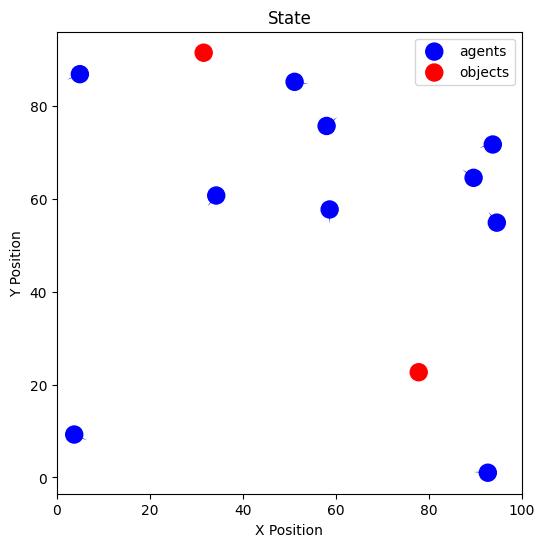

In [8]:
render(state)

### Wrap the state inside a simulator

In [9]:
from vivarium.simulator import behaviors
from vivarium.simulator.simulator import Simulator
from vivarium.simulator.physics_engine import dynamics_rigid

simulator = Simulator(state, behaviors.behavior_bank, dynamics_rigid)

If you use a python file, you can init a state with a yaml config file ([example](../conf/scene/default.yaml)) that you select in command line : 

<div style="font-size: 85%;">

```python
from vivarium.simulator.states import init_state

@hydra.main(version_base=None, config_path="../conf", config_name="config")
def main(cfg: DictConfig = None) -> None:

    args = OmegaConf.merge(cfg.default, cfg.scene)
    state = init_state(args)
    simulator = Simulator(state, behaviors.behavior_bank, dynamics_rigid)
```
</div>

### Run a simulation and save it

In [10]:
num_steps = 1000

In [11]:
state_history = []

# Run the simulation for num_steps and save the state
for _ in range(num_steps):
    simulator.step()
    state_history.append((simulator.state.entity_state,
                          simulator.state.agent_state, 
                          simulator.state.object_state, 
                          simulator.state.simulator_state
                          ))

The code above is equivalent to the following lines of code (but it also saves the state history in a pickle file):

In [12]:
saving_name="notebook_tutorial"
simulator.start_recording(saving_name)

simulator.run(num_steps=num_steps, save=True, saving_name=saving_name)

simulator.stop_recording()

Already recording
Recording not started yet.


In [13]:
# Load the history from the pickle file
loaded_state_history = simulator.load(saving_name)

### Render the state history

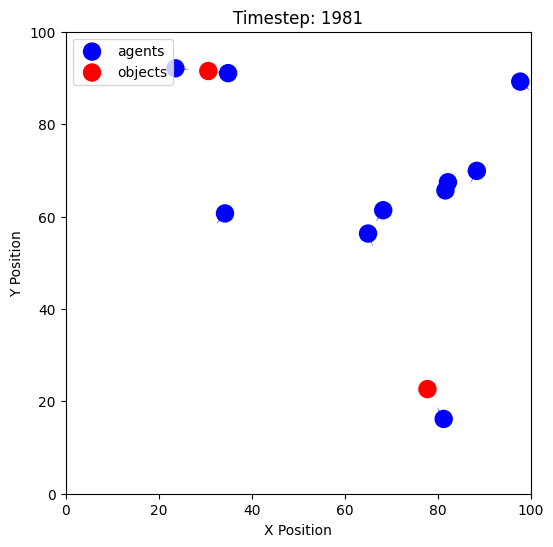

In [14]:
# Here we concatenate the first part (saved with a list), then the second part (saved in the pickle file)
whole_history = state_history + loaded_state_history
skip_frames = 20 # Only plot the state every 20 steps

render_history(whole_history, skip_frames=skip_frames)

# TODO 

- proximter activations 
- neighbor map 
- just say physics is implemented in this file


We can see that agents rush on every entity they have in their field of view ... 

--> This is because ... atm programmed with an aggressive behavior 

Lets see how to define custom behaviors ... 

--> Do you wanna define them directly based on the neighbor map ? Do we introduce neighbor map ... before ?



In [15]:
# Code for custom behaviors ... 

### Refactor ideas

--> Should also remove all the information about proximeters from physics engine (i.e physics engine only an util function to provide help for collisions ...). Think the best thing for an user would surely be to have a kind of file to define an environment (e.g EvoJax, JaxMARL) and import physics fn from physics engine (prox ... would be computed here, or user could define a different type of observation for tis agents). Can be wrapped within a simulator (doesn't wrap a state but an env that can step ...) Then in the simulator use run fns ... that call this step, save the simulation ...
The idea behind this is that wanna do RL / neurevolution only needs a step method, not the whole simulator class (but it is way more convenient to use the interface).

--> Also something more general about agents observation, in braitenberg case they are sensors (could be vision ... right ?) Then we could have agents that have an obs field and 
--> I think what would be interesting is having a field obs (like RL observation for agents, i.e the neighbor map the agents have). I think it is easier to rename it observation so it becomes pretty clear what is is about. 